<a href="https://colab.research.google.com/github/Jaiwanthi-SH/Sentiment-Analysis-for-Product-Reviews/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT NECESSARY LIBRARIES**

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)
!pip install --upgrade tensorflow keras


2.18.0
3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's depen

In [ ]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore')

**LOAD THE DATA**

In [ ]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
jai = GoogleAuth()
jai.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(jai)

In [ ]:
downloaded = drive.CreateFile({'id':'1OgthXzGzMWZylWn9d61BAPt5Cpmvnbm1'}) # replace the id with id of file you want to access
downloaded.GetContentFile('AmazonReview (1).csv')

In [ ]:
import pandas as pd
data = pd.read_csv('AmazonReview (1).csv')

print(data.head(5))
print(data.shape)
print(data.info())

                                              Review  Sentiment
0  Fast shipping but this product is very cheaply...          1
1  This case takes so long to ship and it's not e...          1
2  Good for not droids. Not good for iPhones. You...          1
3  The cable was not compatible between my macboo...          1
4  The case is nice but did not have a glow light...          1
(25000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


**Exploratory Data Analysis**

In [ ]:
# looking for NULL values
print("Null Values:\n", data.isna().sum())

# dropping null values
data = data.dropna()

# again checking for NULL values
print("Null Values after dropping:\n", data.isna().sum())

Null Values:
 Review       1
Sentiment    0
dtype: int64
Null Values after dropping:
 Review       0
Sentiment    0
dtype: int64


In [ ]:
# count of unique values in Sentiment column
data['Sentiment'].value_counts()

,count
Sentiment,
1,5000
2,5000
3,5000
4,5000
5,4999


**Text Cleaning: In this step, we will clean the ‘reviews.text’ column. We will remove the unwanted HTML tags, brackets, or special characters that may be present in the texts. We will use Regex to clean the text.**

In [ ]:
import nltk
nltk.download('punkt')  # Make sure to run this line once to download the tokenizer
nltk.download('punkt_tab')  # Make sure to run this line once to download the tokenizer


print(nltk.data.find('tokenizers/punkt'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


/root/nltk_data/tokenizers/punkt


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Ensure 'punkt' is downloaded
nltk.download('punkt')

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to clean reviews
def clean_reviews(text):
    if isinstance(text, str):  # Check if the text is a string
        text = text.lower()  # Convert to lower case
        text = word_tokenize(text)  # Tokenization of words
        text = [word for word in text if word not in stop_words]  # Stop words removal
    else:
        text = []  # Handle non-string or NaN values as empty list
    return text

# Handle non-string values in the 'Review' column
data['Review'] = data['Review'].astype(str)  # Convert all to strings
data['Review'] = data['Review'].fillna('')   # Fill NaN values with empty strings

# Apply the cleaning function
data['Review'] = data['Review'].apply(clean_reviews)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Tokenization & Text Encoding: In this step, we will use tokenization to first generate the tokens. For this, we will use Tokenizer from the Tensorflow library. And we will encode the text using the same**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

# Initialize the tokenizer
tokenizer = Tokenizer()

# Convert all the reviews to a list to pass it as a parameter to fit_on_texts
reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)

# Generate text sequences (list of lists)
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

# Set the maximum number of words in a sequence
max_words = 500

# Pad sequences to ensure they all have the same length
X = pad_sequences(text_sequences, maxlen=max_words)

# One hot encoding the Sentiment column
data = pd.get_dummies(data, columns=['Sentiment'])

# Generate the output labels y
y = data[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4', 'Sentiment_5']]

# Print the shapes of X and y
print(X.shape, y.shape)

(24999, 500) (24999, 5)


**Train-Test Split: In this step, we will split our dataset into training and testing datasets. We will split the dataset into 80-20%, i.e. 80% for the training and 20% for testing.**

In [ ]:
pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenization
tokenizer = Tokenizer()
reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

# Padding sequences
max_words = 500
X = pad_sequences(text_sequences, maxlen=max_words)

# The sentiment columns are already one-hot encoded, so we don't need to apply pd.get_dummies again
# Generate the output labels y
y = data[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4', 'Sentiment_5']]

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Print the shapes of the training and testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19999, 500) (5000, 500) (19999, 5) (5000, 5)


Model Building, Compiling andLet’s Training
1. Build the Model: In this step, let’s build our model using RNN.

In [ ]:
# Creating a RNN model
rnn = Sequential(name="Simple_RNN")
rnn.add(Embedding(len(tokenizer.word_index)+1,
						max_words,
						input_length=max_words))

rnn.add(SimpleRNN(128,activation='relu',return_sequences=True))

rnn.add(SimpleRNN(64,activation='relu',return_sequences=False))

rnn.add(Dense(5, activation='softmax'))

# printing model summary
print(rnn.summary())

Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


2. Compiling the model and Model Evaluation: Let’s compile and train the model we defined in the above step. Then we will see the accuracy of the model on the test dataset.

In [ ]:
# Compiling model
rnn.compile(
	loss="categorical_crossentropy",
	optimizer='adam',
	metrics=['accuracy']
)

# Training the model
history = rnn.fit(X_train, y_train,
						batch_size=64,
						epochs=2,
						verbose=1,
						validation_data = (X_test, y_test))

# Printing model score on test data
print("Simple_RNN Score---> ", rnn.evaluate(X_test, y_test, verbose=1))

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy: 0.2905 - loss: 1.5214 - val_accuracy: 0.4084 - val_loss: 1.3149
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.5127 - loss: 1.1398 - val_accuracy: 0.4400 - val_loss: 1.2603
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.4406 - loss: 1.2535
Simple_RNN Score--->  [1.2602813243865967, 0.4399999976158142]


Text(0, 0.5, 'Loss')

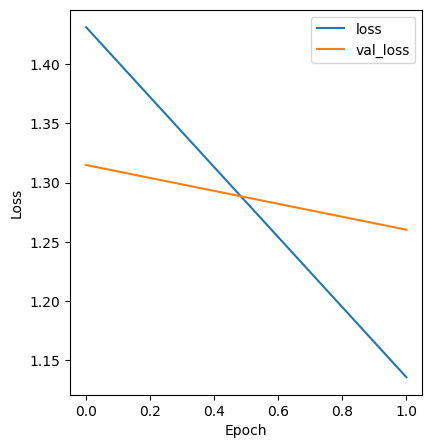

In [ ]:
metrics = history.history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

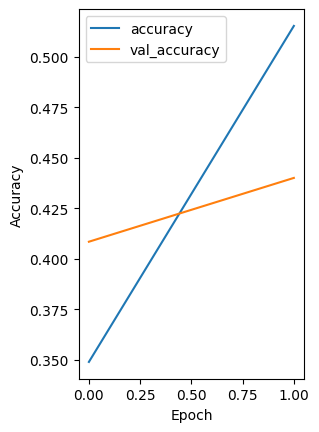

In [ ]:
# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

**LSTM ( Long Short Term Memory)**

In [ ]:
model = Sequential(name="LSTM_Model")
model.add(Embedding(len(tokenizer.word_index)+1,
					max_words,
					input_length=max_words))

# adding a LSTM layer
model.add(LSTM(150, return_sequences=False))
BatchNormalization()
model.add(Dropout(0.5))

#adding a dense layer with activation function of relu
model.add(Dense(50, activation='relu'))
BatchNormalization()
model.add(Dropout(0.5))

# adding the final output activation with activation function of softmax
model.add(Dense(5, activation='softmax'))

# printing model summary
print(model.summary())

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize and limit the vocabulary size
tokenizer = Tokenizer(num_words=5000)
reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

# Determine vocabulary size (if not limiting)
vocab_size = len(tokenizer.word_index) + 1  # Consider increasing this if needed

# Padding sequences
X = pad_sequences(text_sequences, maxlen=500)

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=500))
model.add(GRU(units=128, return_sequences=False))
model.add(Dense(units=5, activation='softmax'))

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    verbose=1,
                    validation_data=(X_test, y_test))

# Evaluate the model
print("GRU model Score---> ", model.evaluate(X_test, y_test, verbose=1))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 469s 1s/step - accuracy: 0.3191 - loss: 1.4868 - val_accuracy: 0.4358 - val_loss: 1.2659
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy: 0.5474 - loss: 1.0694 - val_accuracy: 0.4774 - val_loss: 1.2123
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.6470 - loss: 0.8729 - val_accuracy: 0.4566 - val_loss: 1.2954
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.4516 - loss: 1.2974
GRU model Score--->  [1.2954384088516235, 0.45660001039505005]


**Classification Report**


Text(0, 0.5, 'Accuracy')

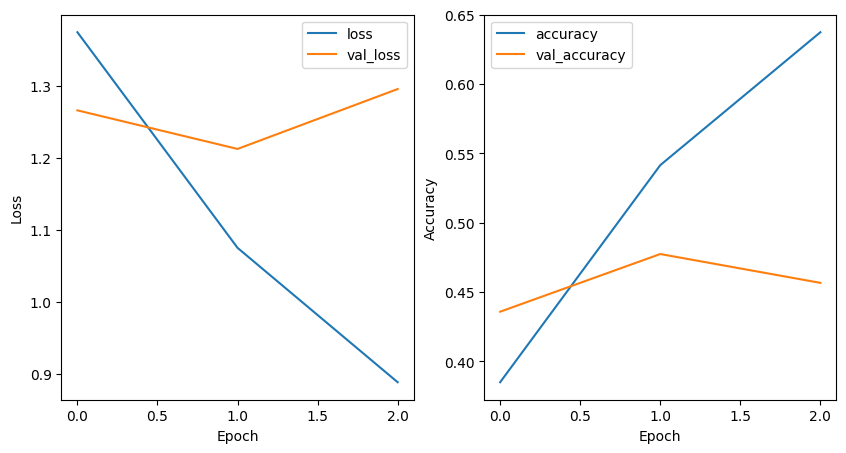

In [ ]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
		metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step


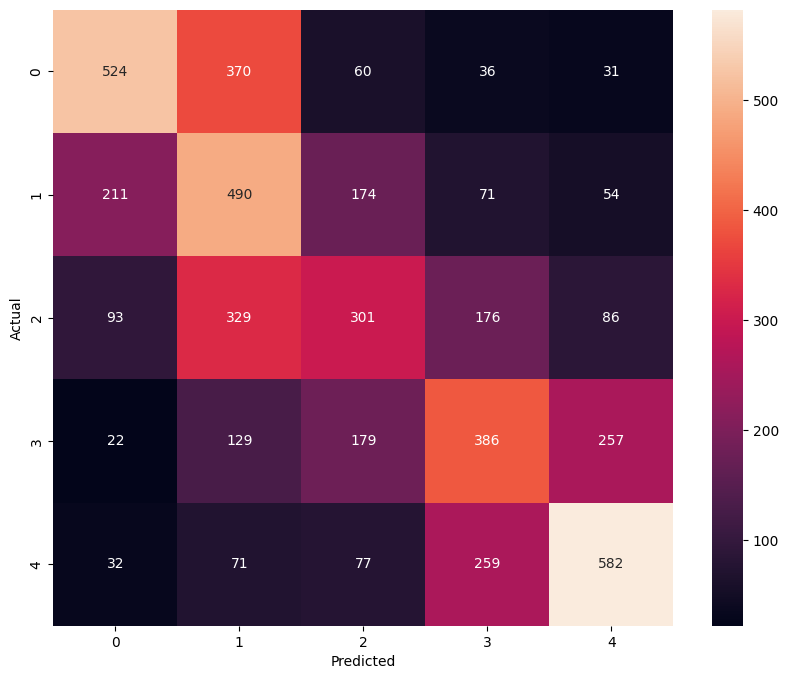

In [ ]:
# converting y_test tht was one hot encoded to one column fo rconfusion matrix
y_true = np.argmax(y_test.values, axis=1)
y_true.shape

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.59      0.51      0.55      1021
           1       0.35      0.49      0.41      1000
           2       0.38      0.31      0.34       985
           3       0.42      0.40      0.41       973
           4       0.58      0.57      0.57      1021

    accuracy                           0.46      5000
   macro avg       0.46      0.46      0.46      5000
weighted avg       0.47      0.46      0.46      5000



**Testing the trained model**

In [ ]:
def predict_review_rating(text):
    # Tokenize the input text
    text_sequences_test = tokenizer.texts_to_sequences([text])

    # Pad the sequence to ensure it matches the input length expected by the model
    testing = pad_sequences(text_sequences_test, maxlen=max_words)

    # Predict the rating (output class) using the trained model
    y_pred_test = np.argmax(model.predict(testing), axis=1)

    # Return the predicted rating
    return y_pred_test[0] + 1

# Testing the prediction function
rating1 = predict_review_rating('Worst product')
print("The rating according to the review is: ", rating1)

rating2 = predict_review_rating('Awesome product, I will recommend this to other users.')
print("The rating according to the review is: ", rating2)

rating3 = predict_review_rating('This product is okay')
print("The rating according to the review is: ", rating3)

rating4 = predict_review_rating('I would like to recommend some improvements though')
print("The rating according to the review is: ", rating4)

rating5= predict_review_rating('This product is amazing')
print("The rating according to the review is: ", rating5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
The rating according to the review is:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
The rating according to the review is:  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
The rating according to the review is:  3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
The rating according to the review is:  4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
The rating according to the review is:  5
